In [108]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import graphviz as gr
from tqdm import tqdm
random.seed(10)

In [109]:
def fn_variance(data, ddof=0): 
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [112]:
def fn_generate_cov(dim): #dim is dimension
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [176]:
def fn_generate_data(tau,N,p,p0,corr,conf = True):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    
    if conf==False:
        conf_mult = 0 
    else:
        conf_mult=1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(2,1,[p,1])
    
    beta0[p0:p] = 0 
    Y = (tau-conf_mult*C*0.1)*T+X@beta0+conf_mult*0.8*C+err
    
    if conf==False:     #if confounder=false, we only generate Y,T,X, otherwise, generate Y,T,X,C
        return (Y,T,X) 
    else:
        return (Y,T,X,C)
    


def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

In [202]:
tau=3
N=1000
p=1
p0=1
corr=0.5

## 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment andsome observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases

-a.Data Generating Process

In [185]:
Y,T,X=fn_generate_data(tau,N,p,p0,corr,conf = False) #DGP#
#Y is the outcome 
#T is the treatment allocation 
#X is the covariate

-b.DAG

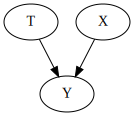

In [198]:
g1 = gr.Digraph()
g1.edge("T", "Y")
g1.edge("X", "Y")
g1

-c.Monte Carlo without controling covariate

In [177]:
estDict = {} #not control covariate
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf=False)
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 230.41it/s]


In [178]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.009785824002652191, RMSE=0.5285764854546036, size=0.059
N=1000: bias=0.0018928133359914572, RMSE=0.15724121427307639, size=0.052


-d.Monte Carlo with controlling covariate 

In [179]:
estDict = {} #control for covariate
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf=False)
        covars = np.concatenate([T,X],axis = 1)
        mod = sm.OLS(Y,sm.add_constant(covars))
        res = mod.fit()
        tauhat = res.params[1]
        se_tauhat = res.HC1_se[1]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 182.46it/s]


In [180]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.004415168652520104, RMSE=0.19740025945322262, size=0.049
N=1000: bias=-0.002136708943523738, RMSE=0.06494482255276045, size=0.058


-e.
One real life example of randomly assigned treatment could be medicine testing experiment. For example,in the expriment on the effect of covid vaccine, people are randomly assigned into two groups. People in the treatment group get real vaccine, but people in the control group get fake vaccine. After a few weeks or months, researchers will collect the infectious rate or death rate of covid in both groups, and check if there is significant difference between two groups. However, the treatment of real vaccine is not the only determinant here; ages might be another variables that researchers look on, since Covid might have a bigger healthy impact on senior people than young people. 

## 2. Simulate a DGP with a confounder

-a.DGP

In [175]:
Y,T,X,C=fn_generate_data(tau,N,p,p0,corr,conf = True)
#Y is the outcome,
#T is the treatment allocation
#X is the covariate 
#C is the confounders

-b.DAG

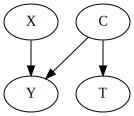

In [199]:
g2 = gr.Digraph()
g2.edge("C", "Y")
g2.edge("X", "Y")
g2.edge("C", "T")
g2

-c.Monte Carlo without control confounder

In [181]:
estDict = {} #not control covariate
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X,C = fn_generate_data(tau,N,p,p0,corr,conf=True)
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 238.61it/s]


In [182]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.016421689992018693, RMSE=0.5772553248067815, size=0.052
N=1000: bias=-0.003229156811613643, RMSE=0.18319173142207418, size=0.045


-d.Monte Carlo with Controlling Confounder

In [183]:
estDict = {} #control for covariate
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X,C = fn_generate_data(tau,N,p,p0,corr,conf=True)
        covars = np.concatenate([T,X,C],axis = 1)
        mod = sm.OLS(Y,sm.add_constant(covars))
        res = mod.fit()
        tauhat = res.params[1]
        se_tauhat = res.HC1_se[1]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 184.33it/s]


In [184]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.01460184936301475, RMSE=0.20126556526190134, size=0.057
N=1000: bias=-0.0031056593047888155, RMSE=0.06287424239693856, size=0.035


-d.   A possible real life of example could be regular exercise. Let's assume that the treatment is randomly assigned milk from a NGO, and the outcome is the healthy body. Regular excercise can help absorbing the nutrition in the milk and thus indirectly makes one's body healthier. Regular excercise can also improve one's muscle strength, and thus directly make one's body healthier. 

## 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

In [190]:
def fn_generate_data_sbias(tau,N,p,p0,corr,conf = True):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+1 # 1 confounder and variable for randomizing treatment
    
    if conf==False:
        conf_mult = 0 
    else:
        conf_mult=1
        
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,0].reshape([N,1]) # confounder
    X = allX[:,1:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(2,1,[p,1])
    Z = X+0.2*T
    
    beta0[p0:p] = 0 
    Y = (tau-conf_mult*C*0.1)*T+Z@beta0+conf_mult*0.8*C+err
    
    if conf==False:     #if confounder=false, we only generate Y,T,X, otherwise, generate Y,T,X,C
        return (Y,T,Z) 
    else:
        return (Y,T,Z,C)

a.DGP

In [191]:
Y,T,Z=fn_generate_data_sbias(tau,N,p,p0,corr,conf = False) #DGP

b.DAG

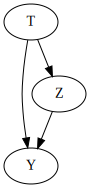

In [200]:
g3 = gr.Digraph()
g3.edge("T", "Y")
g3.edge("T", "Z")
g3.edge("Z", "Y")
g3

c. Monte Carlo without control

In [192]:
estDict = {} #not control covariate
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        fn_generate_data_sbias(tau,N,p,p0,corr,conf = False)
        Yt = Y[np.where(T==1)[0],:]
        Yc = Y[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:04<00:00, 230.71it/s]


In [193]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.30899682295084185, RMSE=0.3089968229508418, size=0.0
N=1000: bias=0.30899682295084185, RMSE=0.3089968229508418, size=0.0


-d. Monte Carlo with Control

In [194]:
estDict = {} #control for covariate
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,Z=fn_generate_data_sbias(tau,N,p,p0,corr,conf = False)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Y,sm.add_constant(covars))
        res = mod.fit()
        tauhat = res.params[1]
        se_tauhat = res.HC1_se[1]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 176.64it/s]


In [195]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.0010446184897130565, RMSE=0.1931639266135417, size=0.042
N=1000: bias=0.0019825005110417136, RMSE=0.06419495945474434, size=0.05


-e.A real life example could be the followings: Exercise is treatment; Healthy food is the selection bias; Healthy body is the outcome. Because one is trying to do excersie to get a fit body, he/she does not purchase junk food any more, and thus his/her body becomes healthier. This is the indirect approach with bias. The direct approach example could be that one do exercise, but this person does not control what he/she eats every day. He/she still has a healthy body because he/she does exercise everyday.